# Train an Oracle model with the complete traffic captures

In our use case, we suppose this model is given at the end of a Federated Learning training among organisations. Each one participates by providing its traffic samples, which potentially vary in data distribution and traffic nature, such as benign, DDoS, or other attacks. For the sake of testing, we train a model in the old-fashioned way.

In [1]:
%reload_ext autoreload
%autoreload 2
import threadpoolctl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from intellect.model.torch.model import Mlp
from intellect.io import dump, create_dir, load
from intellect.inspect import set_seed
from intellect.scoring import compute_metric_percategory
from intellect.dataset import portions_from_data

threadpoolctl.threadpool_limits(limits=2);
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
mpl.rcParams['figure.dpi']= 70

The following cell defines all the parameters.

In [6]:
# parameters

# model parameters
N_HIDDEN_LAYERS = 8
N_HIDDEN_UNITS = 32
DROPOUT_HIDDEN = 0.15
DROPOUT_INPUT = 0.05
BATCH_NORM = False
ACTIVATION = "Tanh"
OUTPUT_ACTIVATION = "LogSigmoid"

# training parameters
BATCH_SIZE = 256
MAX_EPOCHS = 1000
EPOCHS_WO_IMPROVE = 20

# dataset parameters
DATASET_PORTIONS = (0.6, 0.1, 0.1, 0.2)
DATASET = "./dataset_shrinked.h5"
BENIGN_LABELS = ["BENIGN"]

OUTPUT_DIR = "train_output/"

Load the dataset and split it into 4 portions, but consider only train and validation for this step.

In [3]:
def get_dataset():
    set_seed()
    return portions_from_data(DATASET, normalize=True, benign_labels=BENIGN_LABELS, ratios=DATASET_PORTIONS)
train, validation, _, _ = get_dataset()
cols = ["Global"] + [v for v in train._y.value_counts().sort_values(ascending=False).index.values]

In [4]:
create_dir(OUTPUT_DIR)

Proceed with the Oracle network creation and training.

In [ ]:
set_seed()
oracle: Mlp = Mlp(train.features, train.n_classes, N_HIDDEN_UNITS, N_HIDDEN_LAYERS,
                  dropout_hidden=DROPOUT_HIDDEN, dropout_input=DROPOUT_INPUT, batch_norm=BATCH_NORM,
                  activation=ACTIVATION, final_activation=OUTPUT_ACTIVATION)
#oracle.cuda()
history = oracle.fit(train, validation_dataset=validation, batch_size=BATCH_SIZE, max_epochs=MAX_EPOCHS,
                     epochs_wo_improve=EPOCHS_WO_IMPROVE, metric=accuracy_score);
#oracle.cpu()

Save the obtained model and its history, and visualise the history metrics.

In [ ]:
oracle.save(OUTPUT_DIR + "oracle")
history_df = pd.DataFrame(history)
dump(history_df, OUTPUT_DIR + "oracle_history.csv")

Plot history and reload data.

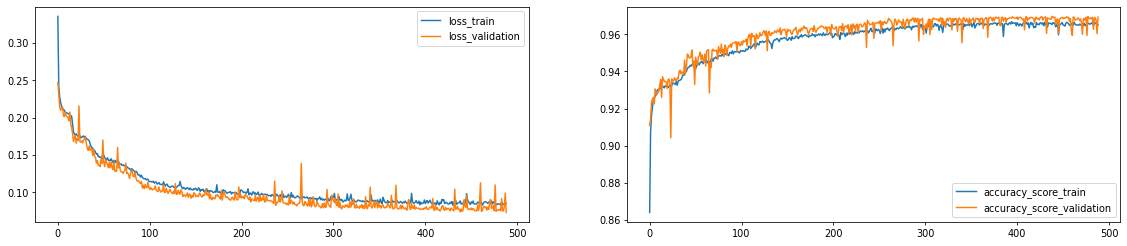

In [8]:
oracle = Mlp.load(OUTPUT_DIR + "oracle.pt")
history_df = load(OUTPUT_DIR + "oracle_history.csv", index_col=0)
fig, axs = plt.subplots(1,2, figsize=(20,4))
history_df[["loss_train", "loss_validation"]].plot(ax=axs[0]), history_df[["accuracy_score_train", "accuracy_score_validation"]].plot(ax=axs[1]);

Finally, test the oracle model against the validation set, used for the early stop condition.

In [7]:
oracle: Mlp = Mlp.load(OUTPUT_DIR + "oracle")
pd.DataFrame(compute_metric_percategory(validation.y, oracle.predict(validation.X), validation._y, scorer=accuracy_score),
             index=["Oracle Accuracy"], columns=cols)

,Global,BENIGN,DrDoS_SNMP,UDP-lag,PortScan,DoS Hulk,DDoS,Syn,NetBIOS,DrDoS_MSSQL,DrDoS_UDP,DrDoS_LDAP,DrDoS_NTP,Portmap,DrDoS_DNS,DrDoS_NetBIOS,MSSQL,DoS GoldenEye,DrDoS_SSDP,UDP,LDAP,TFTP,FTP-Patator,SSH-Patator,DoS slowloris,DoS Slowhttptest,Bot,UDPLag,Web Attack Brute Force,Web Attack XSS,WebDDoS,Infiltration,Web Attack Sql Injection,Heartbleed
Oracle Accuracy,0.96967,0.974052,1.0,0.993,0.999,0.745,0.978,0.994,1.0,1.0,1.0,1.0,0.998,0.996,0.995,1.0,1.0,0.989,1.0,1.0,1.0,1.0,0.982346,0.517827,0.968966,0.990909,0.591837,0.888298,0.92,0.876923,0.0,0.5,0.0,0.0
